In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import FaceCNN
import torch

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [3]:
import cv2
import os

faces = [
    '29_0_4_20170103235130284.jpg.chip.jpg',
    '29_0_4_20170103235516820.jpg.chip.jpg',
    '29_0_4_20170103235840396.jpg.chip.jpg',
    '29_1_0_20170104022706451.jpg.chip.jpg',
    '29_1_0_20170104023227077.jpg.chip.jpg',
    '67_0_0_20170111171747651.jpg.chip.jpg',
    '67_1_0_20170110152923990.jpg.chip.jpg'
]
ages = np.array([29, 29, 29, 29, 29, 67, 67])
genders = np.array([0, 0, 0, 1, 1, 0, 1])

def load_image(path):
    img = cv2.imread(path)
    assert img is not None, "No Image"
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(float)
    img_rgb /= 255.0
    img_rgb = (img_rgb - mean) / std
    return img_rgb

images = list(map(load_image, map(lambda x: os.path.join('../UTKFace/', x), faces)))
images = np.stack(images)

In [4]:
images.shape

(7, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.570283224400871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.0947855124582584].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.413420479302832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831932773109244..2.1461597739532494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.895658263305322..2.2489082969432315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.032280160972686..2.6399999999999997].
Clipping input data to the

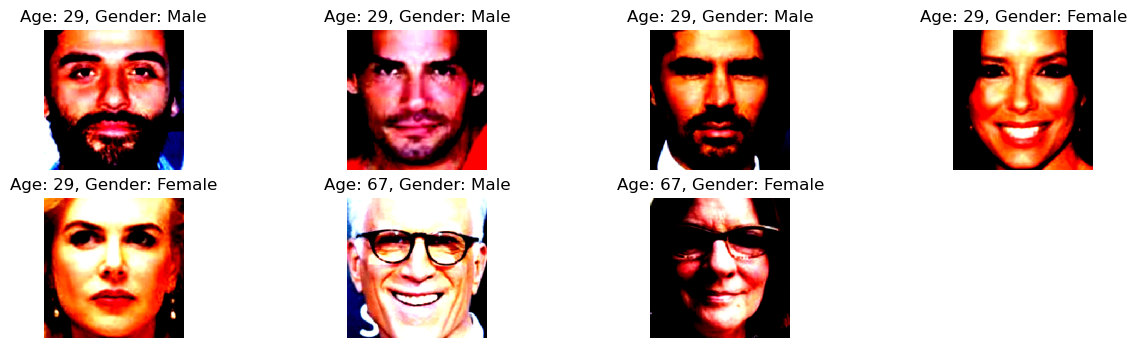

In [5]:
plt.figure(figsize=(15, 4))
for i, im in enumerate(images, 1):
    plt.subplot(2, 4, i)
    plt.imshow(im)
    plt.title(f"Age: {ages[i-1]}, Gender: {['Male', 'Female'][genders[i-1]]}")
    plt.axis('off')
plt.show()

In [6]:
images.transpose(0, 3, 1, 2).shape

(7, 3, 224, 224)

In [7]:
tensors = images.transpose(0, 3, 1, 2)
tensors = torch.from_numpy(tensors)
tensors.shape

torch.Size([7, 3, 224, 224])

In [8]:
tensors.device

device(type='cpu')

In [9]:
model = FaceCNN().to('cuda')
model.load_state_dict(torch.load('face_model.pth', map_location='cuda'))
model.eval()

with torch.no_grad():
    input_tensor = tensors.to('cuda').float() 
    
    pth_results = model(input_tensor)
    
    pth_results = [r.cpu().numpy() for r in pth_results]

print(f"Results shape: {[r.shape for r in pth_results] if isinstance(pth_results, list) else pth_results.shape}")

Results shape: [(7, 1), (7, 1)]


In [10]:
pth_results

[array([[34.30006 ],
        [35.77697 ],
        [33.471905],
        [33.81623 ],
        [34.107315],
        [66.93931 ],
        [59.020733]], dtype=float32),
 array([[3.5474939e-18],
        [5.0907824e-12],
        [1.4694246e-18],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.4622009e-17],
        [1.0000000e+00]], dtype=float32)]

In [11]:
pth_ages = pth_results[0]
pth_genders = pth_results[1]

In [12]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(ages, pth_ages)

4.9303483963012695

In [13]:
pth_genders

array([[3.5474939e-18],
       [5.0907824e-12],
       [1.4694246e-18],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.4622009e-17],
       [1.0000000e+00]], dtype=float32)

In [14]:
pth_genders_binary = (pth_genders > 0.5).astype(int)
pth_genders_binary

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_true=genders, y_pred=pth_genders_binary, target_names=['Male', 'Female']))

              precision    recall  f1-score   support

        Male       1.00      1.00      1.00         4
      Female       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [16]:
import onnxruntime

onnx_inputs = images.copy().transpose(0, 3, 1, 2).astype(np.float32)
print(f"Input length: {len(onnx_inputs)}")
# print(f"Sample input: {onnx_inputs}")

ort_session = onnxruntime.InferenceSession(
    "./face_estimator.onnx", providers=["CUDAExecutionProvider"]
)

Input length: 7


/opt/conda/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [17]:
onnx_ages = []
onnx_genders = []
for i in onnx_inputs:
    i = (np.expand_dims(i, axis=0), )
    # print(i.shape)
    onnxruntime_input = {input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), i)}
    age, gender = ort_session.run(None, onnxruntime_input)
    onnx_ages.append(age[0])
    onnx_genders.append(gender[0])
onnx_ages = np.stack(onnx_ages)
onnx_genders = np.stack(onnx_genders)
onnx_ages.shape, onnx_genders.shape

((7, 1), (7, 1))

In [18]:
mean_absolute_error(ages, onnx_ages.flatten())

4.930361270904541

In [19]:
onnx_genders

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [20]:
onnx_genders_binary = (onnx_genders > 0.5).astype(int)
onnx_genders_binary

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1]])

In [21]:
print(classification_report(y_true=genders, y_pred=onnx_genders_binary.flatten(), target_names=['Male', 'Female']))

              precision    recall  f1-score   support

        Male       1.00      1.00      1.00         4
      Female       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [22]:
np.allclose(pth_ages.flatten(), onnx_ages.flatten())

True

In [23]:
np.allclose(pth_genders_binary.flatten(), onnx_genders.flatten())

True